In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np



# Load INS data
ins_data = pandas.read_csv('csv/2-vectornav-ins.csv')
ins_data = ins_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
ins_data['time'] = pandas.to_datetime(ins_data['time'])
ins_data['time'] = (ins_data['time'] - ins_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
ins_data = ins_data.set_index('time')

# Load GPS Fix (raw) data
fix_data = pandas.read_csv('csv/2-vectornav-fix.csv')
fix_data = fix_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
fix_data['time'] = pandas.to_datetime(fix_data['time'])
fix_data['time'] = (fix_data['time'] - fix_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
fix_data = fix_data.set_index('time')



# Load IMU Data
imu_data = pandas.read_csv('csv/2-vectornav-imu.csv') 
imu_data = imu_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
imu_data['time'] = pandas.to_datetime(imu_data['time'])
imu_data['time'] = (imu_data['time'] - imu_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
imu_data = imu_data.set_index('time')

    

# Load Pacmod Speed Data
# pacmod parsed_txt/vehicle_speed is gets corrupt rows, so we will use as_tx/vehicle_speed
pacmod_speed = pandas.read_csv('csv/2-pacmod-as_tx-vehicle_speed.csv')
pacmod_speed['time'] = pandas.to_datetime(pacmod_speed['time'])
pacmod_speed['time'] = (pacmod_speed['time'] - pacmod_speed['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
# Additionally, there is an factor offset between parsed_txt/vehicle_speed and as_tx/vehicle_speed for whatever reason
# Use 2.237
pacmod_speed['.data'] = pacmod_speed['.data']*2.237
pacmod_speed = pacmod_speed.set_index('time')

# Load Pacmod Steer Data
pacmod_steer = pandas.read_csv('csv/2-pacmod-parsed_tx-steer_rpt.csv')
pacmod_steer = pacmod_steer.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
pacmod_steer['time'] = pandas.to_datetime(pacmod_steer['time'])
pacmod_steer['time'] = (pacmod_steer['time'] - pacmod_steer['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
pacmod_steer = pacmod_steer.set_index('time')


# Add some basic calculations to dataframes ...

# Mangitude of speed
ins_data['.mag_speed'] = (ins_data['.NedVel.y']**2 + ins_data['.NedVel.x']**2)**(1/2)

# Add ins speed to IMU dataframe 
imu_data['ins_vel'] = 0.0
for t in imu_data.index:
    imu_data.at[t,'ins_vel'] = ins_data.iloc[ins_data.index.get_loc(t,method='nearest')]['.mag_speed']
    

# ENU Frame - subtract 90 from yaw
yaw = (90 - ins_data['.RPY.z']) * np.pi/180
ins_x_vel = ins_data['.NedVel.y'] 
ins_y_vel = ins_data['.NedVel.x'] 

# Local velocity at IMU location
ins_data['.LocalVel.x'] = np.multiply(ins_x_vel,np.cos(yaw)) + np.multiply(ins_y_vel,np.sin(yaw))
ins_data['.LocalVel.y'] = -np.multiply(ins_x_vel,np.sin(yaw)) + np.multiply(ins_y_vel,np.cos(yaw))
del yaw, ins_x_vel, ins_y_vel # clear unused variables
imu_data

,.header.seq,.header.frame_id,.gps_time,.Mag.x,.Mag.y,.Mag.z,.Accel.x,.Accel.y,.Accel.z,.Gyro.x,.Gyro.y,.Gyro.z,.Temp,.Pressure,ins_vel
time,,,,,,,,,,,,,,,
0.000000,13361,vectornav,1.266945e+09,0.0,0.0,0.0,-0.522194,-0.369159,-9.998274,-0.018315,0.001394,-0.001137,0.0,0.0,1.717633
0.019960,13362,vectornav,1.266945e+09,0.0,0.0,0.0,-0.388047,-0.405782,-9.588663,0.007059,-0.003691,0.000743,0.0,0.0,1.711808
0.040099,13363,vectornav,1.266945e+09,0.0,0.0,0.0,-0.391195,-0.274625,-9.622240,-0.024199,0.003544,0.000920,0.0,0.0,1.705647
0.059968,13364,vectornav,1.266945e+09,0.0,0.0,0.0,-0.408275,-0.300097,-10.086546,-0.015502,0.002079,0.001560,0.0,0.0,1.683194
0.079919,13365,vectornav,1.266945e+09,0.0,0.0,0.0,-0.472643,-0.085636,-9.763033,0.008683,0.000771,0.001319,0.0,0.0,1.678317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724.632229,49595,vectornav,1.266946e+09,0.0,0.0,0.0,-0.183921,0.276102,-9.765024,-0.000359,0.000097,0.000180,0.0,0.0,0.007994
724.652301,49596,vectornav,1.266946e+09,0.0,0.0,0.0,-0.203688,0.272100,-9.789581,-0.000758,0.001052,-0.000341,0.0,0.0,0.007994
724.672301,49597,vectornav,1.266946e+09,0.0,0.0,0.0,-0.165560,0.298277,-9.784327,0.001301,-0.001483,0.000985,0.0,0.0,0.007994


In [2]:
plt.style.use('ggplot')
predicted_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading

for steering,time in zip(pacmod_steer['.manual_input'],pacmod_steer.index):
    V = pacmod_speed.iloc[pacmod_speed.index.get_loc(time,method='nearest')]['.data']
    prediction = predicted_yaw[-1] - (V/3.4)*np.tan(steering/20.0)*0.033 # updated equation. 
    prediction = (prediction + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    predicted_yaw.append(prediction)



In [3]:
imu_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading
for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    y0 = imu_data['.Gyro.z'].iloc[i]
    integration = imu_yaw[-1] + (y0)*(t1-t0)
    integration = (integration + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    imu_yaw.append(integration)


## Integrating Yaw

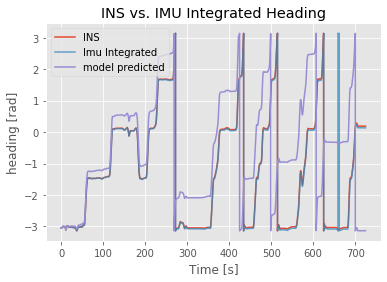

In [5]:
plt.figure()
plt.plot(ins_data.index.values,ins_data['.RPY.z'] * np.pi/180,label='INS') # plot yaw
plt.plot(imu_data.index,imu_yaw,label='Imu Integrated',alpha=0.75)
plt.plot(pacmod_steer.index,predicted_yaw[0:-1],label="model predicted")
plt.xlabel('Time [s]')
plt.ylabel('heading [rad]')
plt.title('INS vs. IMU Integrated Heading');
plt.legend()
plt.show();

Integrated yaw looks pretty good actually. Gyro data is probably less noisy than acceleration data. 

## Integrating Acceleration for Velocity

In [6]:
# Perform integration, Initialize to ins_data[0]
imu_vel_x = np.asarray([ins_data['.NedVel.x'].iloc[0]])
imu_vel_y = np.asarray([ins_data['.NedVel.y'].iloc[0]])

for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    v_x0 = imu_data['.Accel.x'].iloc[i]
    v_y0 = imu_data['.Accel.y'].iloc[i]
    vel_x = imu_vel_x[-1] + ( ((v_x0)*(t1-t0)))
    vel_y = imu_vel_y[-1] + ( ((v_y0)*(t1-t0))) 
    imu_vel_x = np.append(imu_vel_x,vel_x)
    imu_vel_y = np.append(imu_vel_y,vel_y)

imu_vel = (imu_vel_x**2 + imu_vel_y**2)**(1/2)


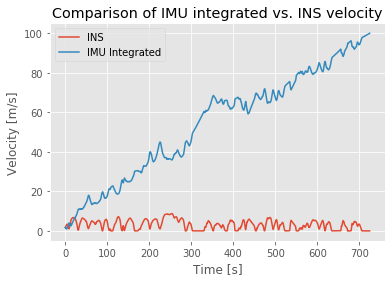

In [7]:
# Plot INS vs Imu Integrated velocity
plt.plot(ins_data.index,ins_data['.mag_speed'],label='INS')
plt.plot(imu_data.index,imu_vel,label="IMU Integrated")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.title('Comparison of IMU integrated vs. INS velocity');

### Where does this drift come from?

Let's observe some acceleration data when the velocity of the golfcart is zero (observed when the magnitude of the GPS speed is < 0.01 m/s)

In [8]:
v_is_zero = ins_data['.mag_speed'] < 1e-2
v_is_zero = ins_data[v_is_zero]['.mag_speed'] >= 0.0
v_is_zero = v_is_zero.index[v_is_zero]

imu_when_zeroV = pandas.DataFrame(columns=imu_data.columns)
for t in v_is_zero:
    imu = imu_data.iloc[imu_data.index.get_loc(t,method='nearest')]
    imu_when_zeroV = imu_when_zeroV.append(imu)

    


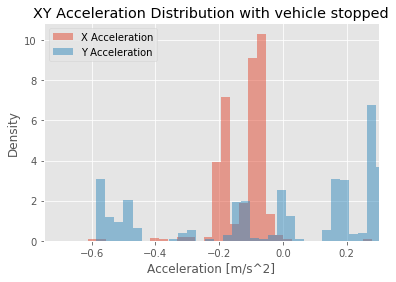

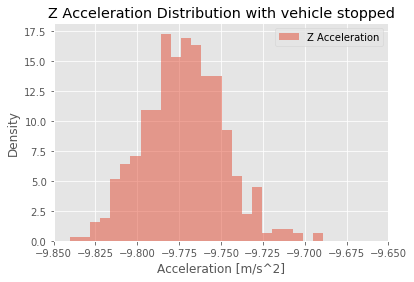

In [9]:
plt.figure()
plt.hist(imu_when_zeroV['.Accel.x'],bins=32,alpha=0.5,label="X Acceleration",density=True)
plt.hist(imu_when_zeroV['.Accel.y'],bins=32,alpha=0.5,label="Y Acceleration",density=True)
plt.xlim([-0.75,0.3])
plt.xlabel('Acceleration [m/s^2]')
plt.ylabel('Density')
plt.title('XY Acceleration Distribution with vehicle stopped')
plt.legend()
plt.figure()

plt.hist(imu_when_zeroV['.Accel.z'],bins=130,alpha=0.5,density=True,label="Z Acceleration")
plt.xlim([-9.85,-9.65])
plt.xlabel('Acceleration [m/s^2]')
plt.ylabel('Density')
plt.title('Z Acceleration Distribution with vehicle stopped')
plt.legend();

In [10]:
# Code accelerations by stop
imu_when_zeroV['group'] = None
c_time = imu_when_zeroV.index[0]
group = 0
for t in imu_when_zeroV.index:
    if np.abs(c_time - t) > 10: # Seperation time in seconds. Tune according to dataset
        group += 1
        c_time = t
    imu_when_zeroV.at[t,'group'] = group
    #print(t,group)
    #print(imu_when_zeroV)

for i in range(imu_when_zeroV['group'].max()):
    i +=1 # range gives 0 to n, need 1 to n
    seq = imu_when_zeroV[imu_when_zeroV['group']==i]['.header.seq']
    
    print("Stop Group # ",i," Start Seq: ",seq.min(), " End Seq: ",seq.max())
    

Stop Group #  1  Start Seq:  21656  End Seq:  21723
Stop Group #  2  Start Seq:  27662  End Seq:  27663
Stop Group #  3  Start Seq:  28774  End Seq:  28833
Stop Group #  4  Start Seq:  29654  End Seq:  29654
Stop Group #  5  Start Seq:  32459  End Seq:  32593
Stop Group #  6  Start Seq:  41031  End Seq:  41043
Stop Group #  7  Start Seq:  45886  End Seq:  46013
Stop Group #  8  Start Seq:  46977  End Seq:  46990
Stop Group #  9  Start Seq:  49383  End Seq:  49595


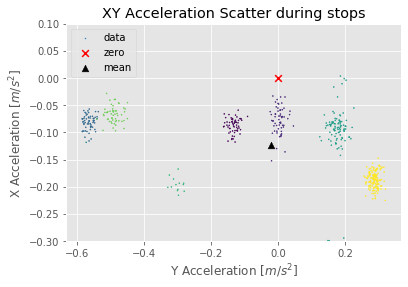

In [11]:
plt.title('XY Acceleration Scatter during stops')
plt.scatter(imu_when_zeroV['.Accel.y'],imu_when_zeroV['.Accel.x'],s=1,c=imu_when_zeroV['group'],label='data')
plt.scatter(0.0,0.0,s=45,color='red',label='zero',marker='x')
plt.scatter(imu_when_zeroV['.Accel.y'].mean(),imu_when_zeroV['.Accel.x'].mean(),s=45,marker='^',color='k',label='mean')
plt.ylim([-0.3,0.1])
plt.xlabel('Y Acceleration [$m/s^2$]')
plt.ylabel('X Acceleration [$m/s^2$]');
plt.legend();

## Subtracting out the bias, and re-integrating

In [12]:
bx = imu_when_zeroV['.Accel.x'].mean()
by = imu_when_zeroV['.Accel.y'].mean()
print("MEAN x: ", bx, " y: ", by)
# Perform integration, Initialize to ins_data[0]
imu_vel_x = np.asarray([ins_data['.NedVel.x'].iloc[0]])
imu_vel_y = np.asarray([ins_data['.NedVel.y'].iloc[0]])

for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    v_x0 = imu_data['.Accel.x'].iloc[i]  - bx
    v_y0 = imu_data['.Accel.y'].iloc[i]  - by
    vel_x = imu_vel_x[-1] + ( ((v_x0)*(t1-t0)))
    vel_y = imu_vel_y[-1] + ( ((v_y0)*(t1-t0))) 
    imu_vel_x = np.append(imu_vel_x,vel_x)
    imu_vel_y = np.append(imu_vel_y,vel_y)

imu_vel = (imu_vel_x**2 + imu_vel_y**2)**(1/2)

MEAN x:  -0.12236577675988712  y:  -0.020010497688605428


Text(0.5, 1.0, 'Comparison of IMU integrated vs. INS velocity')

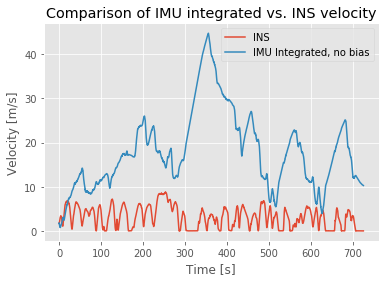

In [13]:
# Plot INS vs Imu Integrated velocity
plt.plot(ins_data.index,ins_data['.mag_speed'],label='INS')
plt.plot(imu_data.index,imu_vel,label="IMU Integrated, no bias")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.title('Comparison of IMU integrated vs. INS velocity')

Unfortunately, the acceleration data is still drifty (though significantly reduced) even with our attempt to remove bias ($b_x, b_y$). It may be a combination of scale factor error and bias error thats causing this drift. 



In [28]:
import numpy.matlib
from scipy import integrate

def integrate_imu_vel(imu_data_):
    imu_data_ = imu_data_.copy() # copy to avoid rewriting
    
    imu_data_['x_vel'] = integrate.cumtrapz(imu_data_['.Accel.x'],x=imu_data_.index,initial=ins_data['.LocalVel.x'][0])
    imu_data_['y_vel'] = integrate.cumtrapz(imu_data_['.Accel.y'],x=imu_data_.index,initial=ins_data['.LocalVel.y'][0])
    imu_data_['mag_vel'] = (imu_data_['x_vel']**2 + imu_data_['y_vel']**2)**(1/2)
    
    return imu_data_


def xyz_accel_scale_bias(C,B,imu_data_):
    """ Returns acceleration with scalefactor C and Bias B """
    imu_data_ = imu_data_.copy() # copy to avoid rewriting
    c_ = np.zeros((3,3))
    #print(c_)
    # Diaganol
    c_[0,0] = C[0]
    c_[1,1] = C[1]
    c_[2,2] = C[2]
    
    c_[0,1] = -C[3]
    c_[0,2] = C[4]
    c_[1,2] = -C[5]
    #print(c_)
    b_ = np.zeros((3,1))
    #print(b_)
    b_[0] = B[0]
    b_[1] = B[1]
    b_[2] = B[2]
    #print(b_)
    xyz_ = np.matmul(c_ ,( np.array([imu_data_['.Accel.x'],imu_data_['.Accel.y'],imu_data_['.Accel.z']]) + b_))
    imu_data_[['.Accel.x','.Accel.y','.Accel.z']] = 0.0
    imu_data_[['.Accel.x','.Accel.y','.Accel.z']] = xyz_.T
    return imu_data_

def least_square_cost(imu_data_):
    diff = ( imu_data_['mag_vel'] - imu_data_['ins_vel'] )**2
    return np.sum(diff) # cost


def minimize_fun(theta):
    C = theta[0:6]
    B = theta[6:9]
    #print(C,B)
    new_imu_data = xyz_accel_scale_bias(C,B,imu_data)
    new_imu_data = integrate_imu_vel(new_imu_data)
    return least_square_cost(new_imu_data)

print(minimize_fun([1,1,1,1,1,1,0,0,0]))
print(minimize_fun([1,1,1,0.1,1,1,0.1,0,0]))

1211959753176.1682
1205791479787.814


In [34]:
import scipy.optimize
from scipy.optimize import Bounds
Bound = Bounds(lb=[0.9,0.9,0.9,-1.0,-1.0,-1.0,-0.2,-0.2,-0.2],ub=[1.1,1.1,1.1,1.1,1.1,1.1,0.2,0.2,0.2])
sol = scipy.optimize.minimize(minimize_fun,[1,1,1,1,1,1,-0.1,0.0,0.1],bounds=Bound)
print(sol)

      fun: 3097867.6183287236
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.66725414e+05,  7.80905625e+06,  0.00000000e+00, -1.23959035e+02,
       -6.85267150e+02,  8.95559788e+02,  1.61537901e+02,  1.63367018e+04,
       -2.80654058e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 460
      nit: 43
   status: 0
  success: True
        x: array([ 0.9       ,  0.9       ,  1.        , -0.06993672, -0.00834857,
        0.01545975,  0.05200781, -0.10979934,  0.13826954])


C = 
 [[ 0.9   0.07 -0.01]
 [ 0.    0.9  -0.02]
 [ 0.    0.    1.  ]]
B = 
 [[ 0.05]
 [-0.11]
 [ 0.14]]


Text(0.5, 1.0, 'IMU Velocity integrated with bias and scale factor removal')

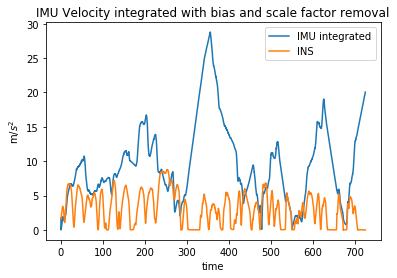

In [37]:
C = sol.x[0:6]
B = sol.x[6:9]

c_ = np.zeros((3,3))
c_[0,0] = C[0]
c_[1,1] = C[1]
c_[2,2] = C[2]

c_[0,1] = -C[3]
c_[0,2] = C[4]
c_[1,2] = -C[5]

b_ = np.zeros((3,1))
b_[0] = B[0]
b_[1] = B[1]
b_[2] = B[2]
print("C = \n", np.array_str(c_, precision=2))
print("B = \n", np.array_str(b_, precision=2))


new_imu_data = xyz_accel_scale_bias(C,B,imu_data)
new_imu_data = integrate_imu_vel(new_imu_data)

new_imu_data.plot(y=['mag_vel','ins_vel'])
plt.legend(['IMU integrated','INS'])
plt.ylabel('m/$s^2$')
plt.title('IMU Velocity integrated with bias and scale factor removal')

## Differentiating INS Velocity to use as reference acceleration


Unforunately, the results are still not good. Let's try using the differentiated INS velocity as the reference acceleration




In [19]:
imu_data['ins_velX'] = 0.0
imu_data['ins_velY'] = 0.0
for t in imu_data.index:
    ct = ins_data.index.get_loc(t,method='nearest')
    imu_data.at[t,'ins_velX'] = ins_data.iloc[ct]['.LocalVel.x']
    imu_data.at[t,'ins_velY'] = ins_data.iloc[ct]['.LocalVel.y']

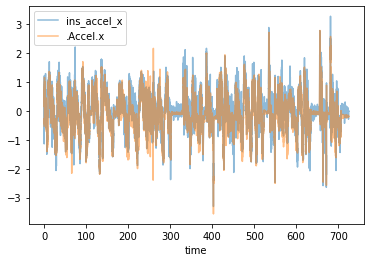

<Figure size 432x288 with 0 Axes>

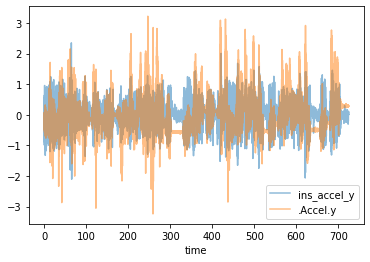

<Figure size 432x288 with 0 Axes>

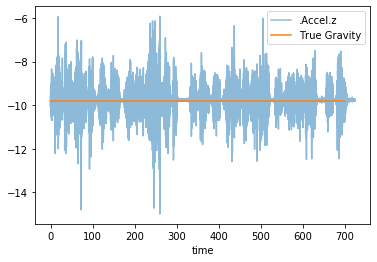

In [21]:
# Differentiate the INS velX and velY


imu_data['ins_accel_x'] = np.diff(imu_data['ins_velX'],prepend=1e-6)/np.diff(imu_data.index,prepend=1-7)
imu_data['ins_accel_y'] = np.diff(imu_data['ins_velY'],prepend=1e-6)/np.diff(imu_data.index,prepend=1-7)
imu_data.plot(y=['ins_accel_x','.Accel.x'],alpha=0.5)

plt.figure()
imu_data.plot(y=['ins_accel_y','.Accel.y'],alpha=0.5)
plt.legend()

plt.figure()
imu_data.plot(y='.Accel.z',alpha=0.5)
plt.plot([0,700],[-9.801,-9.801],label='True Gravity')
plt.legend()

In [23]:
import numpy.matlib
from scipy import integrate

def xyz_accel_scale_bias(C,B,imu_data_):
    """ Returns acceleration with scalefactor C and Bias B """
    imu_data_ = imu_data_.copy() # copy to avoid rewriting

    c_ = np.zeros((3,3))
    c_[0,0] = C[0]
    c_[1,1] = C[1]
    c_[2,2] = C[2]

    c_[0,1] = C[3]
    c_[0,2] = C[4]
    c_[1,2] = C[5]
    c_[1,0] = C[6]
    c_[2,0] = C[7]
    c_[2,1] = C[8]

    
    #print(c_)
    b_ = np.zeros((3,1))
    #print(b_)
    b_[0] = B[0]
    b_[1] = B[1]
    b_[2] = B[2]
    #print(b_)
    xyz_ = np.matmul(c_ ,( np.array([imu_data_['.Accel.x'],imu_data_['.Accel.y'],imu_data_['.Accel.z']]) + b_))
    #imu_data_[['.Accel.x','.Accel.y','.Accel.z']] = 0.0
    imu_data_[['.Accel.x','.Accel.y','.Accel.z']] = xyz_.T
    return imu_data_

def least_square_cost(imu_data_):
    diffx = (imu_data_['.Accel.x'] - imu_data_['ins_accel_x'] )**2 
    diffy = (imu_data_['.Accel.y'] - imu_data_['ins_accel_y'] )**2
    diffz = (imu_data_['.Accel.z'] - -9.801)**2 # 9.801 local gravity @ college station
    return np.sum(    (diffx + diffy + diffz)**(1/2)  )


def minimize_fun(theta):
    C = theta[0:9]
    B = theta[9:12]
#     print(C,B)
    new_imu_data = xyz_accel_scale_bias(C,B,imu_data)
    return least_square_cost(new_imu_data)

def integrate_imu_vel(imu_data_):
    imu_data_ = imu_data_.copy() # copy to avoid rewriting
    
    imu_data_['x_vel'] = integrate.cumtrapz(imu_data_['.Accel.x'],x=imu_data_.index,initial=ins_data['.LocalVel.x'][0])
    imu_data_['y_vel'] = integrate.cumtrapz(imu_data_['.Accel.y'],x=imu_data_.index,initial=ins_data['.LocalVel.y'][0])
    imu_data_['mag_vel'] = (imu_data_['x_vel']**2 + imu_data_['y_vel']**2)**(1/2)
    
    return imu_data_

print(minimize_fun([1,1,1,1,1,1,1,1,1,0,0,0]))
print(minimize_fun([1,1,1,1,1,1,1,1,1,0,0,0]))

510313.23569142853
510313.23569142853


In [25]:
import scipy.optimize
from scipy.optimize import Bounds


Bound = Bounds(lb=[0.9,0.9,0.9,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.2,-0.2,-0.2],ub=[1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,0.2,0.2,0.2])
sol = scipy.optimize.minimize(minimize_fun,[1,1,1,1,1,1,1,1,1,-0.1,0.0,0.1],bounds=Bound)
print(sol)

      fun: 22267.014253179826
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.06228981e+00,  1.07951404e+04, -5.63049980e+00,  7.29050953e-01,
       -5.07861841e+00, -3.41133273e+00, -1.47774699e+00,  4.03815648e-01,
        2.23262759e+00, -6.68042048e+00, -3.05917638e+00,  7.10739550e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1157
      nit: 78
   status: 0
  success: True
        x: array([ 0.9107229 ,  0.9       ,  0.98179123,  0.08396684, -0.00525533,
       -0.0015791 , -0.03561121,  0.02653738, -0.04346967,  0.05603304,
        0.10087863, -0.2       ])


C = 
 [[ 0.91  0.08 -0.01]
 [-0.04  0.9  -0.  ]
 [ 0.03 -0.04  0.98]]
B = 
 [[ 0.06]
 [ 0.1 ]
 [-0.2 ]]


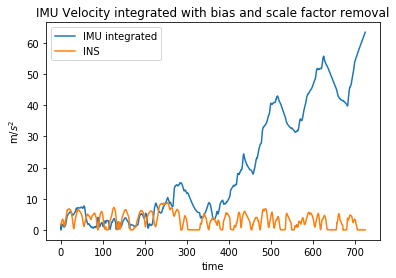

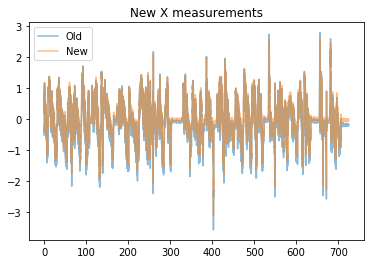

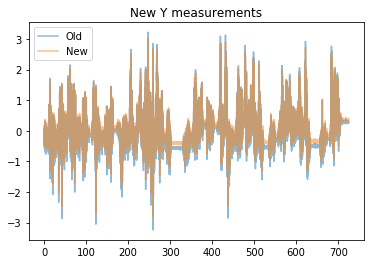

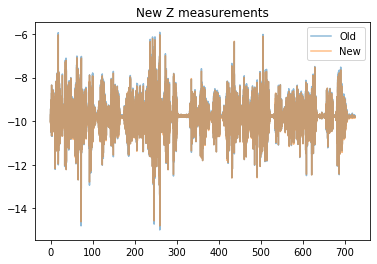

In [26]:
C = sol.x[0:9]
B = sol.x[9:12]

c_ = np.zeros((3,3))
c_[0,0] = C[0]
c_[1,1] = C[1]
c_[2,2] = C[2]

c_[0,1] = C[3]
c_[0,2] = C[4]
c_[1,2] = C[5]
c_[1,0] = C[6]
c_[2,0] = C[7]
c_[2,1] = C[8]

b_ = np.zeros((3,1))
b_[0] = B[0]
b_[1] = B[1]
b_[2] = B[2]
print("C = \n", np.array_str(c_, precision=2))
print("B = \n", np.array_str(b_, precision=2))


new_imu_data = xyz_accel_scale_bias(C,B,imu_data)
new_imu_data = integrate_imu_vel(new_imu_data)

new_imu_data.plot(y=['mag_vel','ins_vel'])
plt.legend(['IMU integrated','INS'])
plt.ylabel('m/$s^2$')
plt.title('IMU Velocity integrated with bias and scale factor removal')

plt.figure()
plt.plot(imu_data.index,imu_data['.Accel.x'],label='Old',alpha=0.5)
plt.plot(new_imu_data.index,new_imu_data['.Accel.x'],label='New',alpha=0.5)
plt.title('New X measurements')
plt.legend()


plt.figure()
plt.plot(imu_data.index,imu_data['.Accel.y'],label='Old',alpha=0.5)
plt.plot(new_imu_data.index,new_imu_data['.Accel.y'],label='New',alpha=0.5)
plt.title('New Y measurements')
plt.legend()


plt.figure()
plt.plot(imu_data.index,imu_data['.Accel.z'],label='Old',alpha=0.5)
plt.plot(new_imu_data.index,new_imu_data['.Accel.z'],label='New',alpha=0.5)
plt.title('New Z measurements')
plt.legend()